# Análisis Exploratorio de Datos (EDA)

## Carga de datos, limpieza de NaN y librerías necesarias

In [15]:
import pandas as pd
import numpy as np
import plotly.express as px

Carga del dataset a utilizar

In [2]:
ruta_dataset = "../data/processed/dataset_final_enriquecido.csv"
df = pd.read_csv(ruta_dataset)
# Aseguramos que la columna 'date' se interprete como fecha, es crucial para la interpolación
df['date'] = pd.to_datetime(df['date'])

print("✅ Dataset enriquecido cargado exitosamente.")
print(f"Dimensiones iniciales: {df.shape}")

✅ Dataset enriquecido cargado exitosamente.
Dimensiones iniciales: (37399, 25)


Imputación de valores faltantes de NOAA mediante datos Open-Meteo

In [5]:
print("\nIniciando limpieza final de NaN...")

# Estrategia A: Rellenar huecos de NOAA con datos de Open-Meteo
mapeo_columnas = {
    'TMAX': 'om_temperature_2m_max', 'TMIN': 'om_temperature_2m_min',
    'TAVG': 'om_apparent_temperature_mean', 'PRCP': 'om_precipitation_sum'
}
for col_noaa, col_om in mapeo_columnas.items():
    if col_noaa in df.columns and col_om in df.columns:
        df[col_noaa] = df[col_noaa].fillna(df[col_om])
        print(f"  -> Huecos en '{col_noaa}' rellenados con datos de '{col_om}'.")

# === CAMBIOS CLAVE AQUÍ ===
# Paso A: Ponemos la fecha como el índice del DataFrame.
df = df.set_index('date')

# Paso B: Ahora la interpolación basada en tiempo funciona.
df = df.interpolate(method='time')

# Paso C: Volvemos a convertir el índice 'date' en una columna normal.
df = df.reset_index()
# ===========================

# Estrategia C: Rellenar cualquier otro posible NaN con 0 (ej. SNWD)
df = df.fillna(0)

print("\n✅ Limpieza final completada. El dataset ya no tiene valores NaN.")


Iniciando limpieza final de NaN...
  -> Huecos en 'TMAX' rellenados con datos de 'om_temperature_2m_max'.
  -> Huecos en 'TMIN' rellenados con datos de 'om_temperature_2m_min'.
  -> Huecos en 'TAVG' rellenados con datos de 'om_apparent_temperature_mean'.
  -> Huecos en 'PRCP' rellenados con datos de 'om_precipitation_sum'.

✅ Limpieza final completada. El dataset ya no tiene valores NaN.


C:\Users\matia\AppData\Local\Temp\ipykernel_32\4289217522.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='time')


Verificacion

In [6]:
print("\n--- Información del Dataset 100% Limpio ---")
df.info()


--- Información del Dataset 100% Limpio ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37399 entries, 0 to 37398
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            37399 non-null  datetime64[ns]
 1   station_name                    37399 non-null  object        
 2   PRCP                            37399 non-null  float64       
 3   SNWD                            37399 non-null  float64       
 4   TAVG                            37399 non-null  float64       
 5   TMAX                            37399 non-null  float64       
 6   TMIN                            37399 non-null  float64       
 7   granizo                         37399 non-null  int64         
 8   latitude                        37399 non-null  float64       
 9   longitude                       37399 non-null  float64       
 10  om_weather_code          

Como podemos observar quedo un dataset sin nulos, ya que para los datos faltantes del NOAA se cargaron los que obtuvimos de la API Open-Meteo.
Luego se promediara cada día entre NOAA y Open-Meteo para obtener una estadística más rigurosa sobre los datos estacionales y poder converger en una única medida para el modelo final.

## Ingeniería de Características

In [8]:
# --- Ingeniería de Características (Feature Engineering) ---
# Extraemos el mes de la columna 'date'. El granizo es muy estacional.
df['mes'] = df['date'].dt.month

# --- Característica de Interacción ---
# Calculamos el rango de temperatura diario. Un rango amplio puede indicar inestabilidad.
df['rango_temp_diario'] = df['TMAX'] - df['TMIN']

print("✅ Nuevas características ('mes', 'rango_temp_diario') creadas exitosamente.")
display(df[['date', 'mes', 'TMAX', 'TMIN', 'rango_temp_diario']].head())

✅ Nuevas características ('mes', 'rango_temp_diario') creadas exitosamente.


,date,mes,TMAX,TMIN,rango_temp_diario
0,2000-01-01,1,24.939999,12.7,12.239999
1,2000-01-01,1,32.800000,17.0,15.800000
2,2000-01-01,1,27.896000,17.5,10.396000
3,2000-01-01,1,31.000000,15.2,15.800000
4,2000-01-02,1,28.900000,11.4,17.500000


Esto se realiza ya que el granizo es estacionario, buscamos ver mejor sus patrones climaticos a travez del tiempo

## Analisis Exploratorio de Datos

### Análisis de Correlación General (Heatmap 2.0)


Generando nuevo heatmap de correlación...


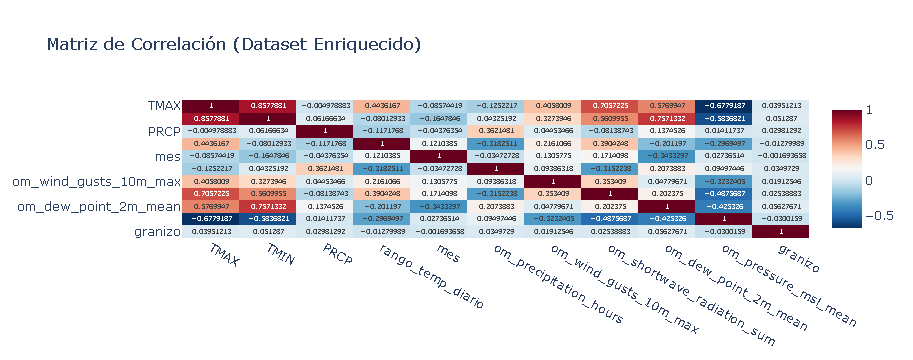

In [16]:
print("\nGenerando nuevo heatmap de correlación...")

# Seleccionamos un conjunto más amplio de variables prometedoras
columnas_interes = [
    'TMAX', 'TMIN', 'PRCP', 'rango_temp_diario', 'mes',
    'om_precipitation_hours', 'om_wind_gusts_10m_max', 
    'om_shortwave_radiation_sum', 'om_dew_point_2m_mean', 
    'om_pressure_msl_mean', 'granizo'
]
df_seleccion = df[columnas_interes]

# Calculamos la matriz de correlación
matriz_correlacion_pro = df_seleccion.corr()

# Creamos la visualización
fig_heatmap = px.imshow(
    matriz_correlacion_pro,
    text_auto=True,
    aspect="auto",
    color_continuous_scale='RdBu_r', # Paleta Rojo-Azul
    title='Matriz de Correlación (Dataset Enriquecido)'
)
fig_heatmap.show()